# 4. Construct Model

xxx

## 4.1 Environment Configuration

### 4.1.1 Import Libraries

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

### 4.1.2 Define Utility Functions

In [2]:
def get_interval(y_pred, alpha=0.99):
    # Calculate prediction intervals using quantiles
    quantile_lower = (1 - alpha) / 2
    quantile_upper = 1 - quantile_lower
    
    # Assuming y_pred is a 1-dimensional array
    sorted_indices = np.argsort(y_pred)
    n = len(y_pred)
    
    # Calculate lower and upper bounds for prediction intervals
    lower_index = int(np.floor(quantile_lower * (n - 1)))
    upper_index = int(np.ceil(quantile_upper * (n - 1)))
    
    lower_bound = y_pred[sorted_indices[lower_index]]
    upper_bound = y_pred[sorted_indices[upper_index]]
    
    # Output the results in the desired format
    return pd.DataFrame({'Prediction': y_pred, 'Lower': lower_bound, 'Upper': upper_bound})


In [3]:
def evaluate_model(y_test, y_pred_int):
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred_int)
    r2 = r2_score(y_test, y_pred_int)
    
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

In [4]:
def get_predictions(x, model):
    # Make predictions
    y_pred = model.predict(x)
    
    # Convert predictions to integers
    y_pred_int = np.round(y_pred).astype(int)

    return y_pred_int

In [5]:
def compute_normalization_params(training_data):
    """
    Compute normalization parameters (mean and standard deviation) from training data.

    Parameters:
        training_data (numpy array or pandas DataFrame): Training data used for computing normalization parameters.

    Returns:
        dict: Dictionary containing normalization parameters (e.g., 'mean' and 'std' for each feature).
    """
    # Compute mean and standard deviation for each feature
    mean = np.mean(training_data, axis=0)
    std = np.std(training_data, axis=0)
    
    # Store the normalization parameters in a dictionary
    normalization_params = {'mean': mean, 'std': std}
    
    return normalization_params

## 4.2 Data Preparation

### 4.2.1 Import Model Parameters

In [6]:
# Best parameters chosen via Grid-Search HPO
best_params = {
    'alpha': 0.9,
    'ccp_alpha': 0.0,
    'criterion': 'friedman_mse',
    'init': None,
    'learning_rate': 0.2,
    'loss': 'squared_error',
    'max_depth': 5,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 50,
    'n_iter_no_change': None,
    'random_state': 42,
    'subsample': 0.8,
    'tol': 0.0001,
    'validation_fraction': 0.1,
    'verbose': 0,
    'warm_start': False
}

# Chosen via a 90% threshold analysis of feature importance
selected_features = ['day_length_07', 'day_length_10', 'day_length_05', 'day_length_11',
       'tempmax_05', 'windspeedmin_07', 'windspeedmin_09', 'humidity_07',
       'day_length_06', 'day_length_02', 'tempmax_06', 'day_length_09',
       'tempmax_07', 'tempmax_02', 'windspeed_04', 'snowdepth_01', 'dew_07',
       'day_length_04', 'tempmax_08', 'day_length_12', 'humidity_05',
       'windspeedmin_10', 'cloudcover_08', 'windspeed_09', 'windspeedmean_06',
       'cloudcover_11', 'solarenergy_02', 'windspeedmax_11', 'uvindex_05',
       'day_length_01', 'solarenergy_03', 'cloudcover_09', 'dew_04',
       'humidity_09']

### 4.2.2 Load Combined Data

In [7]:
# Load combined data
data = pd.read_csv("../data/cleaned/combined.csv")

# Remove metadata columns
data = data.drop(columns=['location', 'lat', 'long', 'alt', 'year', 'bloom_date'])

### 4.2.3 Scale Data

In [8]:
scaler = StandardScaler()

# Split features (X) and target variable (y)
X = data.drop(columns=['bloom_doy'])
y = data['bloom_doy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Subset the data based on the selected features
X_train_scaled = scaler.fit_transform(X_train[selected_features])
X_test_scaled = scaler.transform(X_test[selected_features])

### 4.2.4 Capture Scaling Parameters

In [9]:
# Capture scaling parameters using the X_train dataframe
# Subset it by taking the selected_features
normalization_params = compute_normalization_params(X_train[selected_features])

## 4.3 Train Model

### 4.3.1 Initialize Model with Optimized Parameters

In [10]:
# Initialize and train the Gradient Boosting Regressor
model = GradientBoostingRegressor(**best_params)
model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=5, max_features='sqrt',
                          min_samples_leaf=2, n_estimators=50, random_state=42,
                          subsample=0.8)

### 4.3.2 Evaluate Model

In [11]:
# Make predictions and cast from float to integer
y_pred_int = get_predictions(X_test_scaled, model)

In [12]:
# Model evaluation (MSE and R2)
evaluate_model(y_test, y_pred_int)

Mean Squared Error: 68.61111111111111
R-squared: 0.8498671789407333


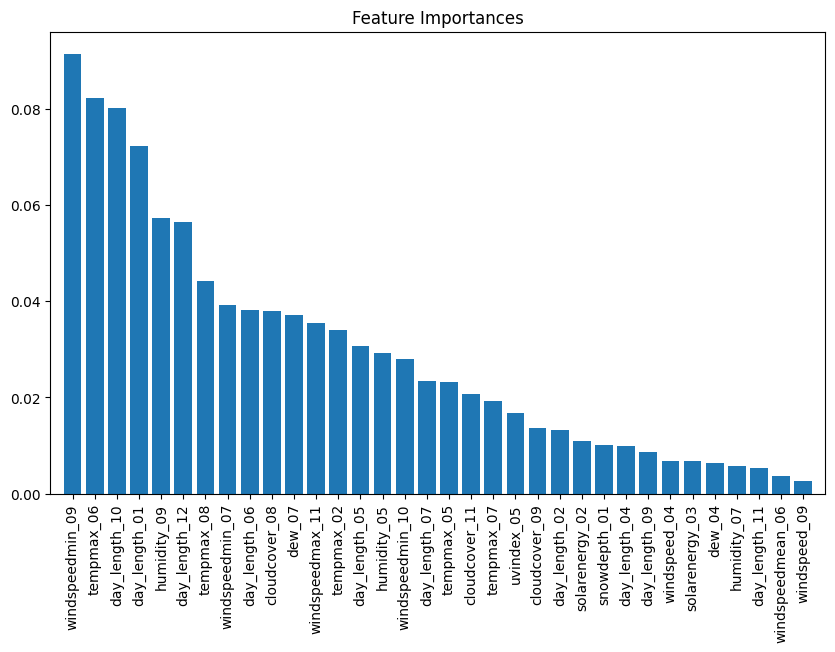

In [16]:
# Get feature importances
feature_importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X[selected_features].shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X[selected_features].shape[1]), X[selected_features].columns[indices], rotation=90)
plt.xlim([-1, X[selected_features].shape[1]])
plt.show()

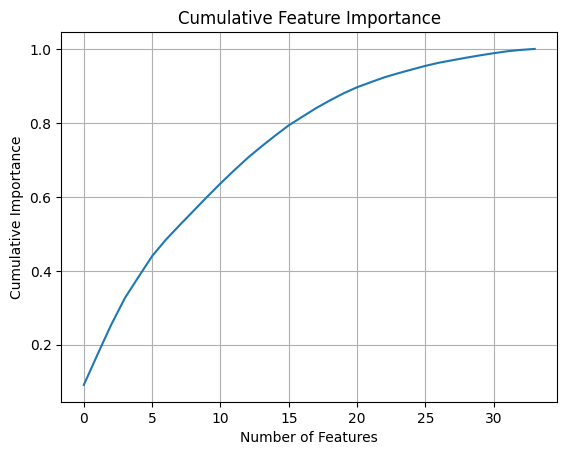

Number of features:  22
Selected Features: Index(['tempmax_07', 'tempmax_11', 'tempmax_02', 'temp_06', 'temp_10',
       'tempmin_08', 'tempmin_07', 'tempmax_06', 'tempmax_09', 'tempmin_11',
       'tempmin_05', 'temp_04', 'tempmin_02', 'tempmax_03', 'tempmin_09',
       'tempmin_10', 'tempmax_01', 'tempmax_05', 'temp_02', 'tempmin_01',
       'temp_05', 'temp_08'],
      dtype='object')


In [18]:
cumulative_importance = np.cumsum(feature_importances[indices])
plt.plot(range(len(cumulative_importance)), cumulative_importance)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)
plt.show()

selected_features = X.columns[indices][:np.argmax(cumulative_importance >= 0.9) + 1]
print("Number of features: ", len(selected_features))
print("Selected Features:", selected_features)

## 4.4 Store Model

### 4.4.1 Set Model Name

In [13]:
# Set the model name
model_name = "GBR-20240218-01"
model_path = f"../models/{model_name}/"

### 4.4.2 Save Model & Normalization Parameters

In [14]:
if not os.path.exists(model_path):
    os.mkdir(model_path)

    joblib.dump(normalization_params, f'{model_path}normalization_params.pkl')
    joblib.dump(model, f'{model_path}model.pkl')
    joblib.dump(selected_features, f'{model_path}feature_list.pkl')
else:
    print("Cannot save model. Model with this name already exists!")

Cannot save model. Model with this name already exists!
